# Stiffness Maximization of a Console in 3d

In [1]:
L = 50.  # length of the console
w, h = 10., 10.  # width and height of the rectangular cross section
resulution = (50, 10, 10)  # resolution of the result in all 3 directions
F = -100.  # value of the vertical load at the free end
E = 21000.0  # Young's modulus
nu = 0.0  # Poisson's ratio

volume_fraction = 0.7

## Initial Solution

Analytic solution for the deflection of the free end:

In [2]:
import numpy as np

# cross section
A = w * h  # area
Iy = w * h**3 / 12  # second moment of inertia around the y axis
Iz = w * h**3 / 12  # second moment of inertia around the z axis
Ix = Iy + Iz  # torsional inertia

# Analytic solution
EI = E * Iy
sol_exact = F * L**3 / (3 * EI)
tol = np.abs(sol_exact / 1000)
sol_exact

-0.23809523809523808

Numerical solution for the deflection of the free end using 3d solid elements:

In [3]:
from sigmaepsilon.solid import Structure, PointData, SolidMesh as FemMesh
from polymesh.space import StandardFrame
from sigmaepsilon.solid.fem.cells import H8 as Cell
from polymesh.grid import gridH8 as grid
from neumann.array import repeat, minmax
import numpy as np

size = Lx, Ly, Lz = (L, w, h)
shape = nx, ny, nz = resulution

gridparams = {
    'size': size,
    'shape': shape,
    'origo': (0, 0, 0),
    'start': 0
}

coords, topo = grid(**gridparams)

A = np.array([
    [1, nu, nu, 0, 0, 0],
    [nu, 1, nu, 0, 0, 0],
    [nu, nu, 1, 0, 0, 0],
    [0., 0, 0, (1-nu)/2, 0, 0],
    [0., 0, 0, 0, (1-nu)/2, 0],
    [0., 0, 0, 0, 0, (1-nu)/2]]) * (E / (1-nu**2))
hooke = repeat(A, topo.shape[0])

# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 3), dtype=bool)
fixity[ebcinds, :] = True

# unit vertical load at (Lx, Ly)
cond = (coords[:, 0] > (Lx-(1e-12))) & \
    (np.abs(coords[:, 1] - (Ly/2)) < 1e-12) & \
    (np.abs(coords[:, 2] - (Lz/2)) < 1e-12)
nbcinds = np.where(cond)[0]
loads = np.zeros((coords.shape[0], 3))
loads[nbcinds, 2] = F

GlobalFrame = StandardFrame(dim=3)

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)

# celldata
frames = repeat(GlobalFrame.show(), topo.shape[0])
cd = Cell(topo=topo, frames=frames)

# set up mesh and structure
mesh = FemMesh(pd, cd, model=hooke, frame=GlobalFrame)
structure = Structure(mesh=mesh)

structure.linsolve()
structure.nodal_dof_solution(store='dofsol')
dofsol = structure.mesh.pd['dofsol'].to_numpy()
structure.mesh.pointdata['x'] = coords + dofsol[:, :3]
sol_fem_3d = dofsol[:, 2].min()
sol_fem_3d

-0.2582212473497534

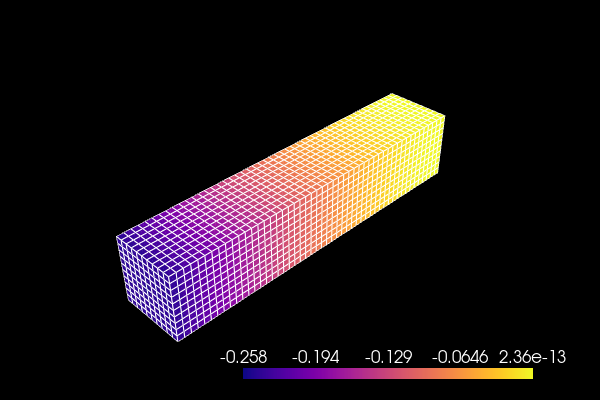

In [4]:
from pyvista import themes

my_theme = themes.DarkTheme()
my_theme.color = 'red'
my_theme.lighting = False
my_theme.show_edges = True
my_theme.axes.box = True

mesh.config['pyvista', 'plot', 'scalars'] = dofsol[:, 2]
mesh.pvplot(notebook=True, jupyter_backend='static', window_size=(600, 400),
            config_key=('pyvista', 'plot'), cmap='plasma', theme=my_theme)

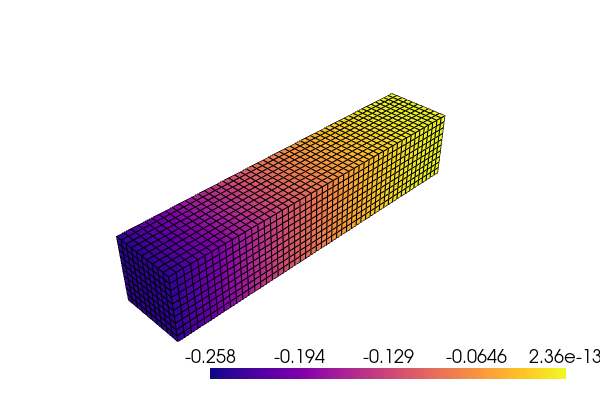

In [5]:
mesh.pvplot(notebook=True, jupyter_backend='static', window_size=(600, 400),
            config_key=('pyvista', 'plot'), cmap='plasma')

In [6]:
#%matplotlib inline

Plot the topology with Matplotlib

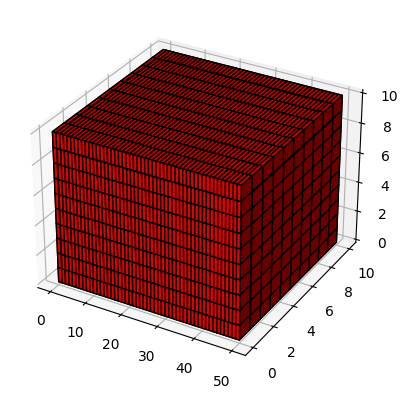

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# prepare some coordinates
x, y, z = np.indices((nx, ny, nz))

# combine the objects into a single boolean array
voxelarray = np.ones((nx, ny, nz), dtype=bool)

# set the colors of each object
colors = np.empty((nx, ny, nz), dtype=object)
colors[:] = 'red'

# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(voxelarray, facecolors=colors, edgecolor='k')

plt.show()

## Optimize for Stiffness

In [8]:
from sigmaepsilon.topopt.oc.SIMP_OC_FEM import OC_SIMP_COMP as OC
from linkeddeepdict import LinkedDeepDict

history = LinkedDeepDict(dict(vol=[], obj=[], pen=[], x=[]))

# iteration parameters
OC_params = {
    'p_start': 1.0,  # SIMP penalty factor
    'p_stop': 2.5,
    'p_inc': 0.1,
    'p_step': 5,
    'q': 0.5,  # smoothing factor
    'vfrac': volume_fraction, 
    'dtol': 0.1,  # to control maximum change in the variables
    'r_max': 3 * max(Lx/nx, Ly/ny),  # for the density filter
    'miniter': 30,
    'maxiter': 1e12,
}
OC_params['neighbours'] = structure.mesh.k_nearest_cell_neighbours(6)
optimizer = OC(structure, summary=True, **OC_params)
r0 = next(optimizer)

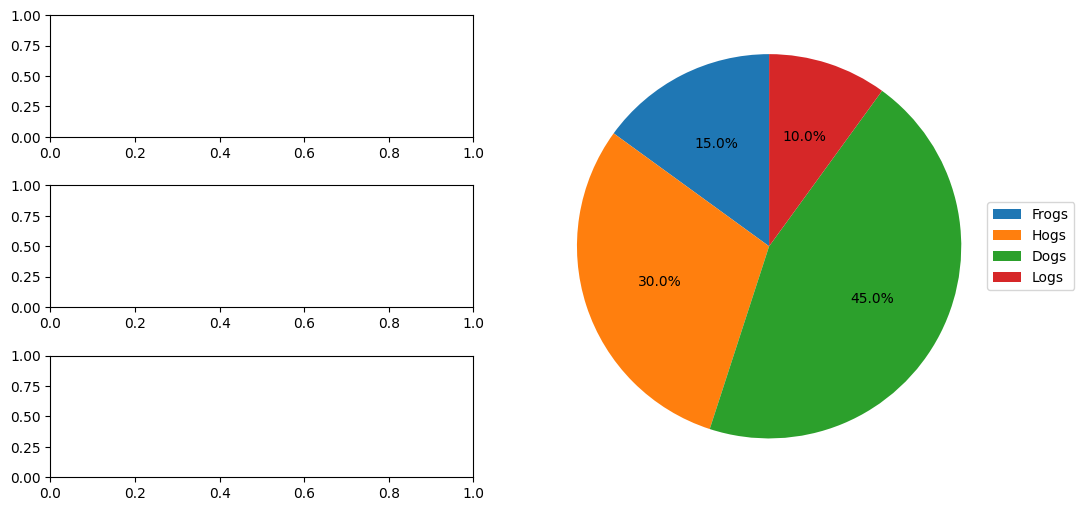

In [9]:
from neumann import histogram
from matplotlib import gridspec
import matplotlib as mpl
from IPython.display import display, clear_output

fig = plt.figure(figsize=(12, 6))  # in inches
fig.patch.set_facecolor('white')
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], hspace=0.4,
                       height_ratios=[1, 1, 1])

ax1 = fig.add_subplot(gs[0, 0])
#ax1.plot(history['obj'])

ax2 = fig.add_subplot(gs[1, 0])
#ax2.plot(history['vol'])

ax3 = fig.add_subplot(gs[2, 0])
#ax3.plot(history['pen'])

ax4 = fig.add_subplot(gs[:, 1])

labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
wedges, texts, autotext = \
        ax4.pie(sizes, autopct='%1.1f%%', startangle=90)
ax4.axis('equal')
ax4.legend(wedges, labels,
           loc="center left",
           bbox_to_anchor=(1, 0, 0.5, 1)) 

def callback_inline(i, obj, vol, pen):
    ax1.plot(i, obj, marker='o', c='b', markersize='2')
    ax2.plot(i, vol, marker='*', c='g', markersize='2')
    ax3.plot(i, pen, marker='*', c='g', markersize='2')
    display(fig)
    clear_output(wait=True)
    plt.pause(0.1)

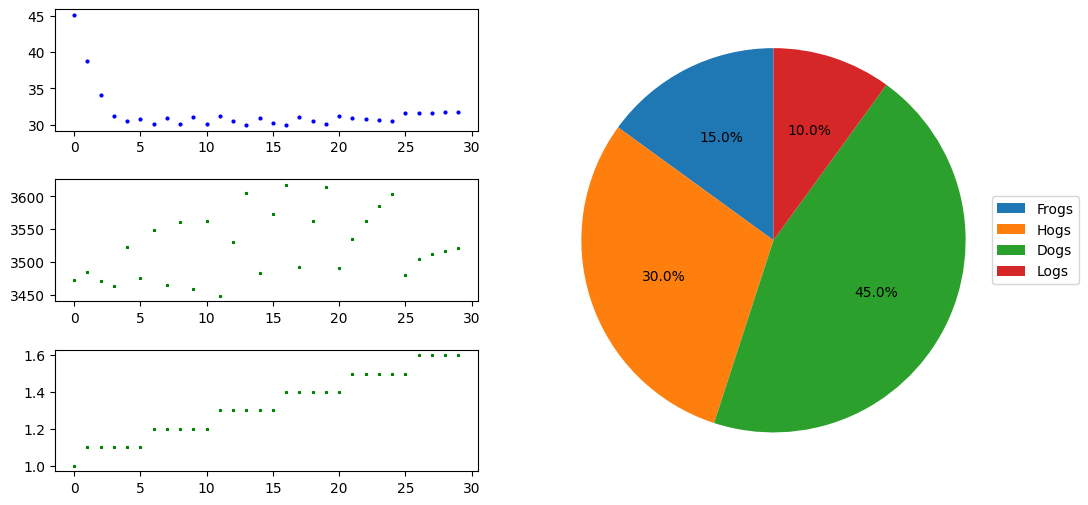

In [10]:
from tqdm import tqdm

#for i in tqdm(range(50)):
for i in range(30):
    r = next(optimizer)
    #if i%5 == 0:
    history['obj'].append(r.obj)
    history['vol'].append(r.vol)
    history['pen'].append(r.pen)
    callback_inline(i, r.obj, r.vol, r.pen)

## Verify Last Result

In [11]:
from polymesh.topo import detach

i = np.where(r.x >= 0.5)[0]
coords = mesh.coords()
topo = mesh.topology()
coords, topo = detach(coords, topo[i])

In [12]:
from polymesh.utils import index_of_closest_point

hooke = repeat(A, topo.shape[0])

# fix points at x==0
cond = coords[:, 0] <= 0.001
ebcinds = np.where(cond)[0]
fixity = np.zeros((coords.shape[0], 3), dtype=bool)
fixity[ebcinds, :] = True

# unit vertical load at (Lx, Ly)
i = index_of_closest_point(coords, np.array([Lx, Ly/2, Lz/2]))
loads = np.zeros((coords.shape[0], 3))
loads[i, 2] = F

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame,
               loads=loads, fixity=fixity)

# celldata
frames = repeat(GlobalFrame.show(), topo.shape[0])
cd = Cell(topo=topo, frames=frames)

# set up mesh and structure
mesh_opt = FemMesh(pd, cd, model=hooke, frame=GlobalFrame)
structure = Structure(mesh=mesh_opt)

structure.linsolve()
dofsol = structure.nodal_dof_solution()
sol_fem_3d_opt = dofsol[:, 2].min()

In [13]:
w0 = sol_fem_3d*F
w_opt = sol_fem_3d_opt*F
w0, w_opt, 100 * w_opt/w0

(25.82212473497534, 40.94771094245125, 158.57607134469743)

In [14]:
v0 = mesh.volume() 
v_opt = mesh_opt.volume()
v0, v_opt, 100 * v_opt/v0

(5000.139079467031, 3328.09531454189, 66.56005486344661)

In [15]:
mesh_opt.plot()

In [16]:
nx * ny * nz, mesh.coords().shape[0] * 3

(5000, 18513)

In [17]:
mesh_opt.topology().shape[0], mesh_opt.coords().shape[0] * 3

(3328, 14541)

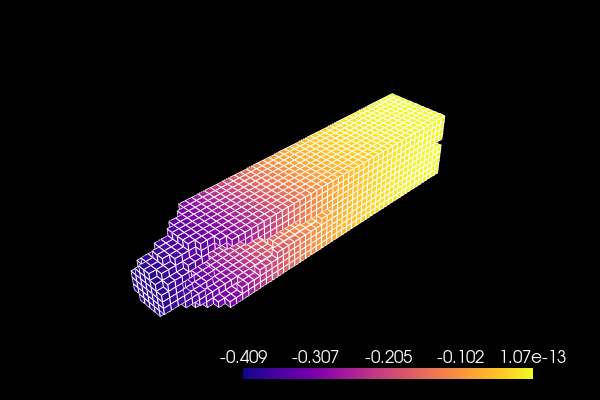

In [18]:
mesh_opt.config['pyvista', 'plot', 'scalars'] = dofsol[:, 2]
mesh_opt.pvplot(notebook=True, jupyter_backend='static', window_size=(600, 400),
            config_key=('pyvista', 'plot'), cmap='plasma', theme=my_theme)